# Lib Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from hcdr.modeling.preproc import preproc_pipeline
from hcdr.data.merged_data import merge_dfs
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import set_config; set_config(display='diagram')

%load_ext autoreload
%autoreload 2

# Get Merged df

In [3]:
"""Code to create new df_merged df"""
# %%time
# df_merged = merge_dfs(df_app="application_train", verbose=True)

'Code to create new df_merged df'

In [4]:
# Use instead of running script to create merged df everytime.
"""Save df_merged"""
df_merged_path = "../raw_data/df_merged.pkl"
# df_merged.to_pickle(df_merged_path)

"""Load df_merged"""
df_merged = pd.read_pickle(df_merged_path)

In [5]:
# df_merged = df_merged.replace(to_replace=np.inf,value=np.nan).replace(to_replace=-np.inf,value=np.nan)

# X & y

In [6]:
X = df_merged.drop(columns=["SK_ID_CURR", "TARGET"])
y = df_merged["TARGET"]

del df_merged

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

del X
del y

# Preprocess df

In [8]:
# Use standard scaler for DL:
preproc = preproc_pipeline(scaler_type="standard")
preproc

Running preprocessor...
scaler_type=standard


Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9412ec0d0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd9412ec250>)])),
                ('scaler', StandardScaler())])

## fit and transform X

In [9]:
preproc.fit(X_train)
X_train_xformed = preproc.transform(X_train)
X_val_xformed = preproc.transform(X_val)

del X_train
del X_val

In [75]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.2, replacement=True)
X_train_xformed_under, y_train_under = undersample.fit_resample(X_train_xformed, y_train)

In [76]:
X_train_xformed.shape, X_train_xformed_under.shape, X_val_xformed.shape

((215257, 691), (104838, 691), (92254, 691))

In [77]:
y_train_under.value_counts()

0    87365
1    17473
Name: TARGET, dtype: int64

In [78]:
y_train_under.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: TARGET, dtype: float64

# Model Setup

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

Kaggle metric is ROC_AUC.

In [81]:
def initialize_model(input_dim):
    """"""
    model = models.Sequential()

    model.add(layers.Dense(16, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    ### Model optimization : Optimizer, loss and metric 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(), # "binary_crossentropy"
                  metrics=[tf.keras.metrics.AUC(), "accuracy"]) # "accuracy"
    return model

input_dim = X_train_xformed.shape[1]
model = initialize_model(input_dim)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 16)                11072     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 11,217
Trainable params: 11,217
Non-trainable params: 0
_________________________________________________________________


In [50]:
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
es = EarlyStopping(patience=5)

In [83]:
history = model.fit(X_train_xformed_under, y_train_under,
                    validation_data=(X_val_xformed, y_val),
                    epochs=1_000, 
                    batch_size=64, 
                    verbose=1,
                    callbacks=[es]
                    )

Epoch 1/1000
1639/1639 [==============================] - 9s 5ms/step - loss: 0.3863 - auc_7: 0.7627 - accuracy: 0.8400 - val_loss: 0.2777 - val_auc_7: 0.7453 - val_accuracy: 0.9100
Epoch 2/1000
1639/1639 [==============================] - 8s 5ms/step - loss: 0.3816 - auc_7: 0.7703 - accuracy: 0.8410 - val_loss: 0.2843 - val_auc_7: 0.7445 - val_accuracy: 0.9076
Epoch 3/1000
1639/1639 [==============================] - 8s 5ms/step - loss: 0.3799 - auc_7: 0.7731 - accuracy: 0.8420 - val_loss: 0.2864 - val_auc_7: 0.7432 - val_accuracy: 0.9095
Epoch 4/1000
1639/1639 [==============================] - 7s 4ms/step - loss: 0.3782 - auc_7: 0.7759 - accuracy: 0.8426 - val_loss: 0.2831 - val_auc_7: 0.7447 - val_accuracy: 0.9080
Epoch 5/1000
1639/1639 [==============================] - 7s 4ms/step - loss: 0.3772 - auc_7: 0.7775 - accuracy: 0.8428 - val_loss: 0.2786 - val_auc_7: 0.7412 - val_accuracy: 0.9113
Epoch 6/1000
1639/1639 [==============================] - 7s 4ms/step - loss: 0.3756 - auc

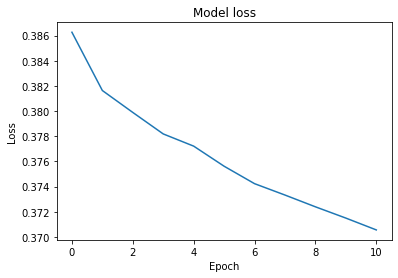

In [84]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)

Baseline ROC_AUC = 0.5

In [15]:
from sklearn.metrics import roc_auc_score

In [85]:
y_prob = model.predict(X_val_xformed)
roc_auc = roc_auc_score(y_val, y_prob)
roc_auc

0.7367952898918037

Baseline Accuracy:

In [86]:
y_train_under.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: TARGET, dtype: float64

In [87]:
(y_prob>0.5).sum()

3989

Text(0.5, 1.0, 'Precision-Recall Curve')

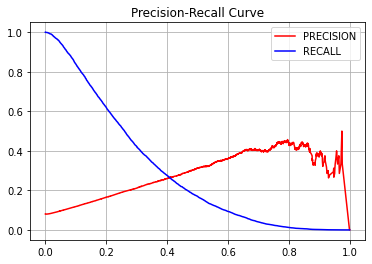

In [88]:
# Plot Precision-Recall curve using sklearn.
from sklearn.metrics import precision_recall_curve
precision, recall, treshold = precision_recall_curve(y_val, y_prob)
  
# Plot the output.
plt.plot(treshold, precision[:-1], c ='r', label ='PRECISION')
plt.plot(treshold, recall[:-1], c ='b', label ='RECALL')
plt.grid()
plt.legend()
plt.title('Precision-Recall Curve')
